# Chapter 9: Beyond Money - Budgets and Barter

In classical Game Theory, we assume **Quasi-Linear Utility**:
$$\text{Utility} = \text{Value} - \text{Payment}$$
This assumes you can always pay. But what if you have a **Budget Constraint** ($B$)?
* If Payment > Budget: Utility drops to $-\infty$ (Bankruptcy).

## Part 1: The Clinching Auction
Imagine selling identical items (like ad clicks) to bidders with strict daily budgets.
* **Standard Ascending Auction:** Fails. If prices rise, a high-value bidder might suddenly go broke and drop to demand 0, crashing the price.
* **The Solution:** The **Clinching Auction**.
    * We raise the price gradually.
    * Instead of asking "Who is left?", we ask "Is the supply so low that you are **guaranteed** to win?"
    * If the total demand of *everyone else* is less than the supply, you mathematically "clinch" the leftover items.

## Part 2: Mechanism Design Without Money (Barter)
What if we can't use money at all?
**The Scenario:** 4 Students have been assigned dorm rooms. They are unhappy. They want to swap.
* **Problem:** Agent A wants B's room. Agent B wants C's room. Agent C wants A's room.
* **Solution:** The **Top Trading Cycle Algorithm (TTCA)**.
    1.  Everyone points to their favorite room.
    2.  This creates a directed graph.
    3.  There is guaranteed to be at least one **Cycle**.
    4.  Agents in the cycle swap houses and leave the game.

Let's visualize the "Pointing Graph" for the dormitory problem.

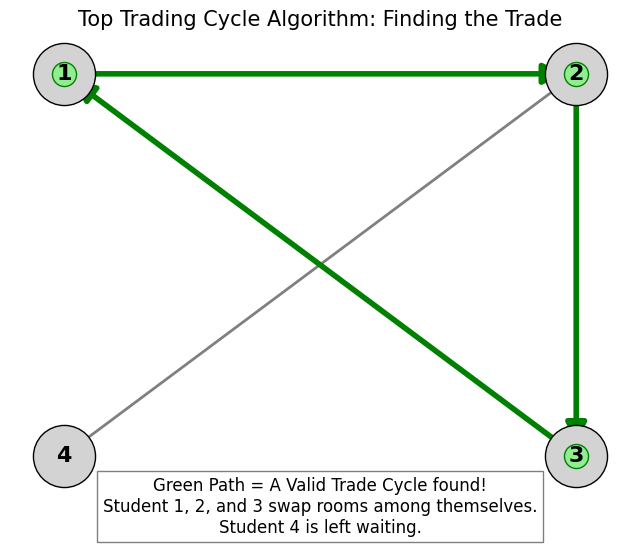

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_ttca_cycle():
    """
    Visualizes one step of the Top Trading Cycle Algorithm.
    Scenario: 4 Students want to swap dorm rooms.
    """
    
    # 1. Setup Agents and their Current Houses
    # Agent 1 has House 1, wants House 2
    # Agent 2 has House 2, wants House 3
    # Agent 3 has House 3, wants House 1
    # Agent 4 has House 4, wants House 2 (But 2 is busy in a cycle)
    
    G = nx.DiGraph()
    
    # Add Nodes (Students/Houses)
    G.add_nodes_from([1, 2, 3, 4])
    
    # Add Edges (Preferences)
    # Edge i -> j means "Student i points to Student j's house"
    edges = [
        (1, 2), # Student 1 wants House 2
        (2, 3), # Student 2 wants House 3
        (3, 1), # Student 3 wants House 1 (CYCLE FORMED!)
        (4, 2)  # Student 4 wants House 2 (No cycle for 4 yet)
    ]
    G.add_edges_from(edges)
    
    # 2. Detect Cycles
    try:
        cycles = list(nx.simple_cycles(G))
        # Filter for the main cycle [1, 2, 3]
        main_cycle = [c for c in cycles if len(c) > 1][0]
    except IndexError:
        main_cycle = []

    # 3. Visualization
    pos = {
        1: (0, 1), # Top Left
        2: (1, 1), # Top Right
        3: (1, 0), # Bottom Right
        4: (0, 0)  # Bottom Left
    }
    
    plt.figure(figsize=(8, 6))
    
    # Draw all nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightgray', edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=2, edge_color='gray')
    
    # Highlight the Cycle
    if main_cycle:
        # Create list of cycle edges: (1,2), (2,3), (3,1)
        cycle_edges = []
        for i in range(len(main_cycle)):
            u = main_cycle[i]
            v = main_cycle[(i + 1) % len(main_cycle)]
            cycle_edges.append((u, v))
            
        nx.draw_networkx_edges(G, pos, edgelist=cycle_edges, edge_color='green', width=4, arrowsize=30)
        nx.draw_networkx_nodes(G, pos, nodelist=main_cycle, node_color='lightgreen', edgecolors='green')
        
    plt.title("Top Trading Cycle Algorithm: Finding the Trade", fontsize=15)
    plt.text(0.5, -0.2, "Green Path = A Valid Trade Cycle found!\nStudent 1, 2, and 3 swap rooms among themselves.\nStudent 4 is left waiting.", 
             ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.axis('off')
    plt.show()

visualize_ttca_cycle()

Now, let's look at the **Clinching Auction** for Budgeted Bidders.
* **Scenario:** Selling 100 Ad Clicks.
* **Bidder A:** Values clicks at \$5, Budget \$20. (Can buy max 4 clicks).
* **Bidder B:** Values clicks at \$3, Budget \$50.
* **Logic:** As price $p$ goes up, buyers can afford fewer items. If Bidder B's demand drops, Bidder A "clinches" the items B can no longer afford.

In [2]:
import math

def run_clinching_auction():
    # Setup
    TOTAL_ITEMS = 10
    
    # Format: {'name': Name, 'val': ValuePerItem, 'budget': TotalBudget}
    bidders = [
        {'id': 'A', 'v': 10, 'B': 20, 'won': 0}, # Rich valuation, poor budget (Max 2 items)
        {'id': 'B', 'v': 4,  'B': 40, 'won': 0}, # Low valuation, rich budget (Max 10 items)
    ]
    
    supply = TOTAL_ITEMS
    price = 0.0
    price_increment = 0.5
    
    print(f"--- Clinching Auction (Items: {TOTAL_ITEMS}) ---")
    
    # Run Auction Loop (Price rises from 0 to max valuation)
    while supply > 0 and price < 12:
        price += price_increment
        
        # 1. Calculate Current Demand for everyone
        demands = {}
        for b in bidders:
            if price > b['v']: 
                d = 0 # Price too high
            elif price == 0:
                d = 999 # Infinite demand at 0
            else:
                # Demand limited by Budget
                max_affordable = math.floor(b['B'] / price)
                # Demand limited by Supply + Won (Can't want more than exists)
                d = min(max_affordable, TOTAL_ITEMS)
            demands[b['id']] = d
            
        # 2. Check for Clinching
        # You clinch if Supply > Sum of Others' Demand
        for b in bidders:
            others_demand = sum([demands[o['id']] for o in bidders if o['id'] != b['id']])
            
            # Available for me = Supply - Others
            # Actually, in strict clinching, we look at residual supply.
            # Simplified: If Others want 8, and Supply is 10, I am GUARANTEED 2.
            
            guaranteed = max(0, TOTAL_ITEMS - others_demand)
            newly_clinched = guaranteed - b['won']
            
            if newly_clinched > 0:
                # We can only clinch what is currently available
                amount = min(newly_clinched, supply)
                
                if amount > 0:
                    b['won'] += amount
                    b['B'] -= amount * price # Pay from budget
                    supply -= amount
                    print(f"Price ${price}: Bidder {b['id']} CLINCHES {amount} items! (Rem Supply: {supply})")
                    
    print("-" * 30)
    print("Final Results:")
    for b in bidders:
        print(f"Bidder {b['id']}: Won {b['won']} items. Remaining Budget: ${b['B']:.2f}")

run_clinching_auction()

--- Clinching Auction (Items: 10) ---
Price $2.5: Bidder B CLINCHES 2 items! (Rem Supply: 8)
Price $3.0: Bidder B CLINCHES 2 items! (Rem Supply: 6)
Price $3.5: Bidder A CLINCHES 2 items! (Rem Supply: 4)
Price $3.5: Bidder B CLINCHES 1 items! (Rem Supply: 3)
Price $4.0: Bidder A CLINCHES 2 items! (Rem Supply: 1)
Price $4.0: Bidder B CLINCHES 1 items! (Rem Supply: 0)
------------------------------
Final Results:
Bidder A: Won 4 items. Remaining Budget: $5.00
Bidder B: Won 6 items. Remaining Budget: $21.50


### Analysis of the Clinching Auction

In the simulation, you should see something counter-intuitive:
* **Bidder A** (High Value \$10) has a small budget (\$20). They can afford at most 2 items.
* **Bidder B** (Low Value \$4) has a huge budget.

As the price rises to **\$4**, Bidder B's demand stays high (they can afford plenty). Bidder A cannot "clinch" anything because B wants them all.
But once the price crosses **\$4**, Bidder B drops out (Price > Value).
* Suddenly, Bidder B's demand goes to 0.
* Bidder A instantly **clinches** the remaining items (up to their budget limit).

This mechanism ensures fairness. Bidder A gets items only when they are "uncontested" or when the competitor drops out, and they pay the price at the specific moment the item was secured.